In [47]:
%load_ext autoreload
%autoreload 2
%pylab
%matplotlib inline

import pandas as pd
import pickle
import numpy as np
import sys
import os
import torch

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
# sys.path.append('/host/projects/sv_experiments/sv_system')
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [10]:
def key2df(keys, delimeter="-"):
    key_df = pd.DataFrame(keys, columns=['key'])
    key_df['spk'] = key_df.key.apply(lambda x: x.split(delimeter)[0])
    key_df['label'] = key_df.groupby('spk').ngroup()
    key_df['origin'] = key_df.spk.apply(lambda x: 'voxc2' if x.startswith('id') else 'voxc1')
    key_df = key_df.set_index('key')

    return key_df

In [19]:
# load embeds and make dataframe
embeds = np.load("../xvector_embeds/sv_embeds.npy")
key = pickle.load(open("../xvector_embeds/sv_keys.pkl", "rb"))
key_df = key2df(key)
label = np.array(key_df.label)

## Gaussian modeling

sample mean and tied precision matrix

In [111]:
def sample_estimator(list_features, num_classes):
    """
    compute sample mean and precision (inverse of covariance)
    input: 
        list_features: list of features. n_features * [n_class x n_samples x feat_dim]
    return: sample_class_mean: list of class mean
             precision: list of precisions
    """
    import sklearn.covariance
    
    group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
    feature_list = [feat[0].shape[1] for feat in list_features]

    sample_class_mean = []
    out_count = 0
    for num_feature in feature_list:
        temp_list = torch.Tensor(num_classes, int(num_feature))
        for j in range(num_classes):
            temp_list[j] = torch.mean(list_features[out_count][j], 0)
        sample_class_mean.append(temp_list)
        out_count += 1
        
    precision = []
    for k in range(len(list_features)):
        X = 0
        for i in range(num_classes):
            if i == 0:
                X = list_features[k][i] - sample_class_mean[k][i]
            else:
                X = torch.cat((X, list_features[k][i] - sample_class_mean[k][i]), 0)
        # find inverse            
        group_lasso.fit(X.cpu().numpy())
        temp_precision = group_lasso.precision_
        temp_precision = torch.from_numpy(temp_precision).float()
        precision.append(temp_precision)
        
    return sample_class_mean, precision

In [364]:
n_classes = 20
chosen_spks = np.random.choice(key_df.spk.unique(), size=n_classes, replace=False)

train_embeds = []
in_val_embeds = []
for spk in chosen_spks:
    spk_embeds = embeds[np.nonzero(key_df.spk == spk)]
    np.random.shuffle(spk_embeds)
    n_samples = len(spk_embeds)
    t_emb = torch.from_numpy(spk_embeds[:int(n_samples*0.8)])
    v_emb = torch.from_numpy(spk_embeds[int(n_samples*0.8):])
    train_embeds.append(t_emb)
    in_val_embeds.append(v_emb)

In [365]:
list_features = [train_embeds]

In [366]:
sample_mean, precision = sample_estimator(list_features, n_classes)

In [367]:
precision = prec_

## Compute mahalonobis scores

In [353]:
def get_Mahalanobis_score(test_features, sample_mean, precision, num_classes, layer_index, magnitude):
    '''
    Compute the proposed Mahalanobis confidence score on input dataset
    return: Mahalanobis score from layer_index
    '''
    Mahalanobis = []
    out_features = test_features
        
    # compute Mahalanobis score
    gaussian_score = 0
    for i in range(num_classes):
        batch_sample_mean = sample_mean[layer_index][i]
        zero_f = out_features - batch_sample_mean
        term_gau = -0.5*torch.mm(torch.mm(zero_f, precision[layer_index]), zero_f.t()).diag()
        if i == 0:
            gaussian_score = term_gau.view(-1,1)
        else:
            gaussian_score = torch.cat((gaussian_score, term_gau.view(-1,1)), 1)
            
    gaussian_score, _ = torch.max(gaussian_score, dim=1)
    Mahalanobis.extend(gaussian_score.cpu().numpy())
        
    return Mahalanobis

In [368]:
in_embeds = torch.from_numpy(np.concatenate(in_val_embeds, axis=0))
out_sample_index = np.nonzero(~key_df.spk.isin(chosen_spks))
out_embeds = torch.from_numpy(
    embeds[np.random.choice(out_sample_index[0], size=len(in_embeds)*1, replace=False)])

In [369]:
print('get Mahalanobis scores')
# m_list = [0.0, 0.01, 0.005, 0.002, 0.0014, 0.001, 0.0005]
m_list = [0.1]
for magnitude in m_list:
    print('Noise: ' + str(magnitude))
    for i in range(len(list_features)): # number of features
        M_in = get_Mahalanobis_score(in_embeds, sample_mean, precision, n_classes, i, magnitude)
        M_in = np.asarray(M_in, dtype=np.float32)
        if i == 0:
            Mahalanobis_in = M_in.reshape((M_in.shape[0], -1))
        else:
            Mahalanobis_in = np.concatenate((Mahalanobis_in, M_in.reshape((M_in.shape[0], -1))), axis=1)
            
        M_out = get_Mahalanobis_score(out_embeds, sample_mean, precision, n_classes, i, magnitude)
        M_out = np.asarray(M_out, dtype=np.float32)
        if i == 0:
            Mahalanobis_out = M_out.reshape((M_out.shape[0], -1))
        else:
            Mahalanobis_out = np.concatenate((Mahalanobis_out, M_out.reshape((M_out.shape[0], -1))), axis=1)

get Mahalanobis scores
Noise: 0.1


In [370]:
# consine score
from sklearn.metrics import roc_curve

def compute_eer(pos_scores, neg_scores):
    score_vector = np.concatenate([pos_scores, neg_scores])
    label_vector = np.concatenate([np.ones(len(pos_scores)), np.zeros(len(neg_scores))])
    fpr, tpr, thres = roc_curve(label_vector, score_vector, pos_label=1)
    eer = np.min([fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))],
                 1-tpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]])
    thres = thres[np.nanargmin(np.abs(fpr - (1 - tpr)))]
    
    return eer

In [371]:
pos_scores = Mahalanobis_in.flatten()
neg_scores = Mahalanobis_out.flatten()
eer = compute_eer(pos_scores, neg_scores)
print("eer: {:.4f}%".format(eer*100))

eer: 17.3397%


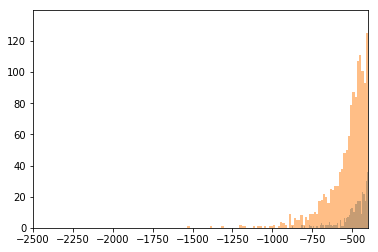

In [358]:
plt.hist(Mahalanobis_in, bins=100, alpha=0.5)
plt.hist(Mahalanobis_out, bins=100, alpha=0.5)
plt.xlim([-2500, -400])
plt.show()

## Cosine score

In [359]:
speaker_model = torch.stack([torch.mean(emb, dim=0, keepdim=True) for emb in train_embeds], dim=0)

In [360]:
from torch.nn.functional import cosine_similarity as cosine_sim

in_scores, _ = torch.max(cosine_sim(speaker_model, in_embeds.unsqueeze(0), dim=2), dim=0)
in_scores = in_scores.numpy().tolist()

out_scores, _ = torch.max(cosine_sim(speaker_model, out_embeds.unsqueeze(0), dim=2), dim=0)
out_scores = out_scores.numpy().tolist()

In [361]:
pos_scores = in_scores
neg_scores = out_scores
eer = compute_eer(pos_scores, neg_scores)
print("eer: {:.4f}%".format(eer*100))

eer: 7.5201%
